In [1]:
import carla
import numpy as np
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import torchvision 
from torch import nn
import queue
import time
from image_processing import *
import os
import pandas as pd

# Initialize latest image path
disk_path = 'G:/carla_data/'

frame_id = 0
starting_time = 0
IMG_WIDTH = 640
IMG_HEIGHT = 480
steer_log = []
last_log_time = None
starting_time = None

## Changing the map

In [2]:
# Connects the client with the server
client = carla.Client('localhost', 2000)

# Load a new map if you want to
world = client.load_world('Town04') # Set the fog=0 for this map

RuntimeError: time-out of 5000ms while waiting for the simulator, make sure the simulator is ready and connected to localhost:2000

### Image preprocessing for model

In [3]:
# Image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Loading the model

In [4]:
import torch
import torchvision.models as models
from pathlib import Path

# Define the model architecture (ResNet-50 in this case)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

# Define the path where the model is saved
MODEL_PATH = Path("carla_models")
MODEL_NAME = "model_checkpoint_v6.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Load the state dict
print(f"Loading model from: {MODEL_SAVE_PATH}")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Set the model to evaluation mode
model.to(device)
model.eval()

Loading model from: carla_models\model_checkpoint_v6.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Prediction of model

In [5]:
# Function to preprocess the image and predict the throttle and steer
def predict_control(image):
    #processed_image = frame_processor(image)
    cropped_processed_image = region_selection(image)
    pil_image = Image.fromarray(cropped_processed_image)
    #path = f"G:/output_pictures/{time.time()}.png"
    #pil_image.save(path)  # DEBUGGING - To check how the tensor input to the model looks like.
    input_tensor = preprocess(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        steer = output.cpu().numpy()
        throttle = 0.4
        #print(steer)
    return throttle, steer

### Controlling the car

### Function for the camera listen and control

In [6]:
# Callback function to process each camera frame
def process_image(image):
    global last_log_time, starting_time
    # Convert the CARLA image to numpy array
    image.convert(carla.ColorConverter.Raw)
    array_raw = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
    array_bgra = np.reshape(array_raw, (image.height, image.width, 4))  # BGRA format
    array_bgr = array_bgra[:, :, :3]  # Convert to BGRA
    array_rgb = array_bgr[:, :, ::-1] # Convert to RGB

    # Predict control based on the current frame
    throttle, steer = predict_control(array_rgb)

    # Apply control to the vehicle
    control = carla.VehicleControl(throttle=float(throttle), steer=float(steer))
    vehicle.apply_control(control)

    # Set starting time only once
    if starting_time is None:
        starting_time = image.timestamp

    # Log once every 1 simulated second
    current_time = image.timestamp
    if last_log_time is None or (current_time - last_log_time) >= 1.0:
        location = vehicle.get_location()
        steer_log.append({
            "timestamp": current_time - starting_time,
            "steer": float(steer[0]),
            "throttle": throttle,
            "x": location.x,
            "y": location.y,
            "z": location.z
        })
        last_log_time = current_time

### Function to move the car

In [7]:
# Function to move spectator with car
def move_with_the_car():
    spectator = world.get_spectator()
    # Here the spectator is being positioned relative to the position of the car - Relative coordinate system
    transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-6,z=2)), 
                                vehicle.get_transform().rotation)
    spectator.set_transform(transform)

In [9]:
# Connect to the Carla server
# Generate a dataset with annotated cropped images and train on that
client = carla.Client('localhost', 2000)
client.set_timeout(5.0)

# Load the world
world = client.get_world()

# Load the blueprint library
blueprint_library = world.get_blueprint_library()

# Set synchronous mode
settings = world.get_settings()
settings.synchronous_mode = True  # Enable synchronous mode
settings.fixed_delta_seconds = 0.1
world.apply_settings(settings)

# Change weather - Talk about both methods in report
weather = world.get_weather()
weather.cloudiness = 100
weather.fog_density = 0 # Use this if you only want to tweak a particular value and not change the other value
weather.precipitation = 40
#weather.precipitation_deposits = 20
#custom_weather = carla.WeatherParameters(    # Here other values may get overwritten
    #cloudiness = 60,
    #precipitation=50.0,           # Rain intensity percentage (0.0 to 100.0)
    #precipitation_deposits=0.0,  # Water accumulation on surfaces (0.0 to 100.0)
    #fog_density=0.0,             # Fog density percentage (0.0 to 100.0)
    #fog_distance=100.0,           # Fog start distance in meters
    #wetness=40.0,                 # Wetness of surfaces (0.0 to 100.0)
    #ice_thickness=0.0,            # Thickness of ice on surfaces (0.0 to 100.0)
    #snow_amount=100.0,             # Intensity of snowfall (0.0 to 100.0)
    #snow_puddles=5.0,             # Water puddles from melted snow (0.0 to 100.0)
    #snow_depth=8.0                # Depth of accumulated snow (0.0 to 100.0)
#)
world.set_weather(weather)

# Spawn a vehicle
vehicle_bp = blueprint_library.filter('vehicle.lincoln.mkz_2020')[0]
spawn_points = world.get_map().get_spawn_points()
spawn_point = spawn_points[1]
shifted_spawn_point = carla.Transform(spawn_point.transform(carla.Location(x = 0)), 
                                      spawn_point.rotation)
vehicle = world.spawn_actor(vehicle_bp, shifted_spawn_point)

# Attach a camera to the vehicle
camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_transform = carla.Transform(carla.Location(x=1.2, z=1.5))
camera_bp.set_attribute("image_size_x", "640")
camera_bp.set_attribute("image_size_y", "480")
camera_bp.set_attribute("fov", "90")
camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)

#starting_time = time.time()
steer_log.clear()
last_log_time = None
starting_time = None
camera.listen(lambda image: process_image(image))

#image_queue = queue.Queue()

# Define the duration in seconds
duration = 120

try:
    # Main loop
    while True:
    #while time.time() - starting_time < duration:
        move_with_the_car()
        
        # Tick the world to update sensor data
        world.tick()

        # # Get the latest image from the camera
        # if not image_queue.empty():
        #     image_array = image_queue.get()

        #     # Predict control values
        #     throttle, steer = predict_control(image_array)

        #     # Apply control to the vehicle
        #     control_car(vehicle, throttle, steer)

except KeyboardInterrupt:
    print("Interrupted, stopping the simulation.")
    for actor in world.get_actors().filter('*vehicle*'):
        actor.destroy()
    for sensor in world.get_actors().filter('*sensor*'):
        sensor.destroy()
        
finally:
    # Clean up actors
    for actor in world.get_actors().filter('*vehicle*'):
        actor.destroy()
    for sensor in world.get_actors().filter('*sensor*'):
        sensor.destroy()

    # Save to CSV file
    df = pd.DataFrame(steer_log)
    df.to_csv("steering_trace_preci40.csv", index=False)
    print("Steering log saved!")
    # Restore settings
    settings.synchronous_mode = False
    world.apply_settings(settings)

    # Restore weather
    world.set_weather(carla.WeatherParameters.Default)

Interrupted, stopping the simulation.
Steering log saved!


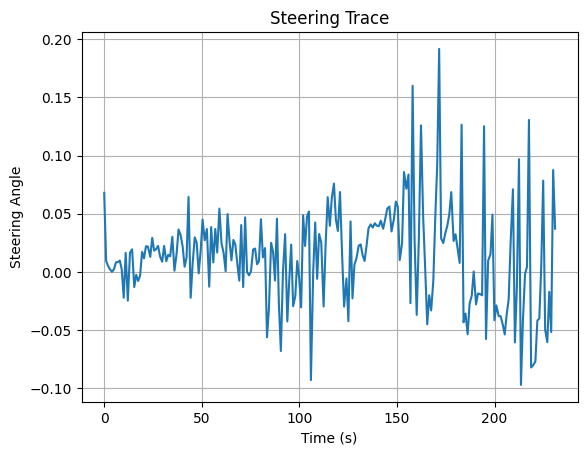

In [10]:
df = pd.read_csv("steering_trace_preci40 - Copy.csv")
plt.plot(df["timestamp"], df["steer"])
plt.xlabel("Time (s)")
plt.ylabel("Steering Angle")
plt.title("Steering Trace")
plt.grid()
plt.savefig('Steer trace - preci40.pdf', dpi=600)
plt.show()

In [9]:
# Clean up actors
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

# Restore settings
settings.synchronous_mode = False
world.apply_settings(settings)

7046

### Plotting steer trace

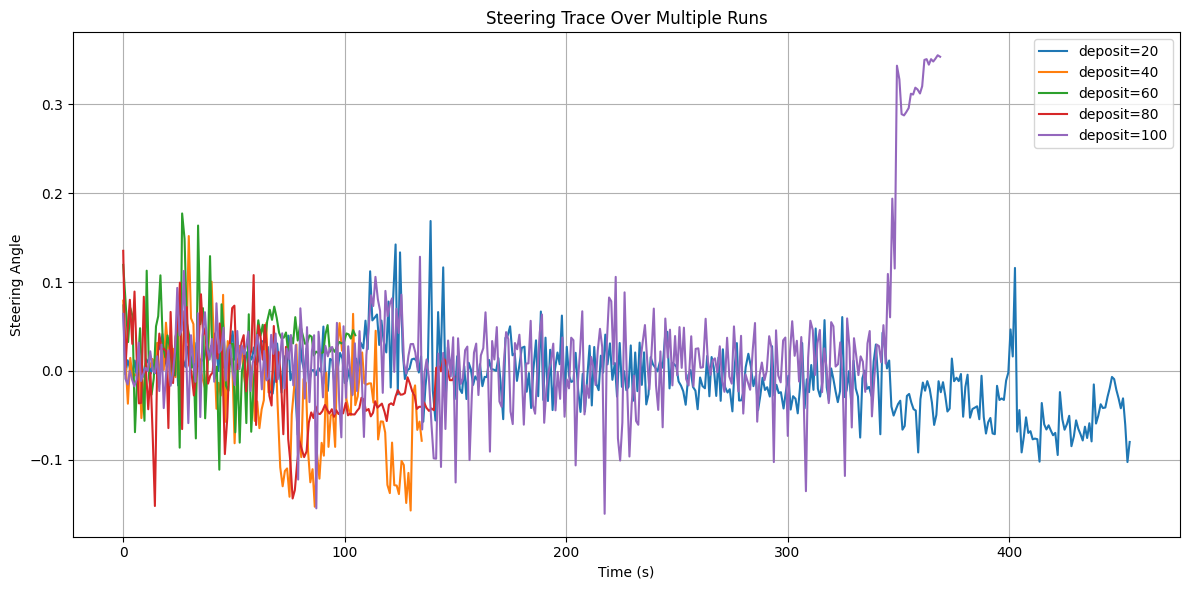

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# List of CSV files
csv_files = [
    "steering_trace_precideposit20.csv",
    "steering_trace_precideposit40.csv",
    "steering_trace_precideposit60.csv",
    "steering_trace_precideposit80.csv",
    "steering_trace_precideposit100.csv"
]

# Optional labels for the legend
labels = ["deposit=20", "deposit=40", "deposit=60", "deposit=80", "deposit=100"]

# Plot each file
plt.figure(figsize=(12, 6))
for csv_file, label in zip(csv_files, labels):
    df = pd.read_csv(csv_file)
    plt.plot(df["timestamp"], df["steer"], label=label)

# Customize the plot
plt.xlabel("Time (s)")
plt.ylabel("Steering Angle")
plt.title("Steering Trace Over Multiple Runs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Steer trace - preci deposit all cases.pdf', dpi=600)
plt.show()